# https://dacon.io/competitions/official/236047/codeshare/7631
### 신용카드 이상 탐지(isolation forest)

In [192]:
import torch # type: ignore
print(torch.backends.mps.is_available())

True


In [174]:
import pandas as pd
train_df = pd.read_csv('./train.csv')
val_df = pd.read_csv('./val.csv')
test_df = pd.read_csv('./test.csv')
submisson_df = pd.read_csv('./sample_submission.csv')

In [175]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113842 entries, 0 to 113841
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      113842 non-null  int64  
 1   V1      113842 non-null  float64
 2   V2      113842 non-null  float64
 3   V3      113842 non-null  float64
 4   V4      113842 non-null  float64
 5   V5      113842 non-null  float64
 6   V6      113842 non-null  float64
 7   V7      113842 non-null  float64
 8   V8      113842 non-null  float64
 9   V9      113842 non-null  float64
 10  V10     113842 non-null  float64
 11  V11     113842 non-null  float64
 12  V12     113842 non-null  float64
 13  V13     113842 non-null  float64
 14  V14     113842 non-null  float64
 15  V15     113842 non-null  float64
 16  V16     113842 non-null  float64
 17  V17     113842 non-null  float64
 18  V18     113842 non-null  float64
 19  V19     113842 non-null  float64
 20  V20     113842 non-null  float64
 21  V21     11

In [176]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train = train_df.drop(['ID'], axis=1)
val = val_df.drop(['ID'], axis=1)
test = test_df.drop(['ID'], axis=1)
test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142498,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,-0.111640,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,0.028645,1.034904
142499,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,0.810312,1.034916
142500,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,1.034963
142501,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,1.034975


In [177]:
train_df = scaler.fit_transform(train) # 정규화 스케일을 학습 데이터에 맞추기. 검증, 테스트 데이터는 학습 데이터의 스케일에 맞춰야함.
train_df = pd.DataFrame(train_df, columns=train.columns)

val_df = scaler.transform(val.drop(columns=['Class']))
val_columns = val.columns[:-1]
val_df = pd.DataFrame(val_df, columns=val_columns)
val_df['Class'] = val['Class']

test_df = scaler.transform(test)
test_df = pd.DataFrame(test_df, columns=test.columns)

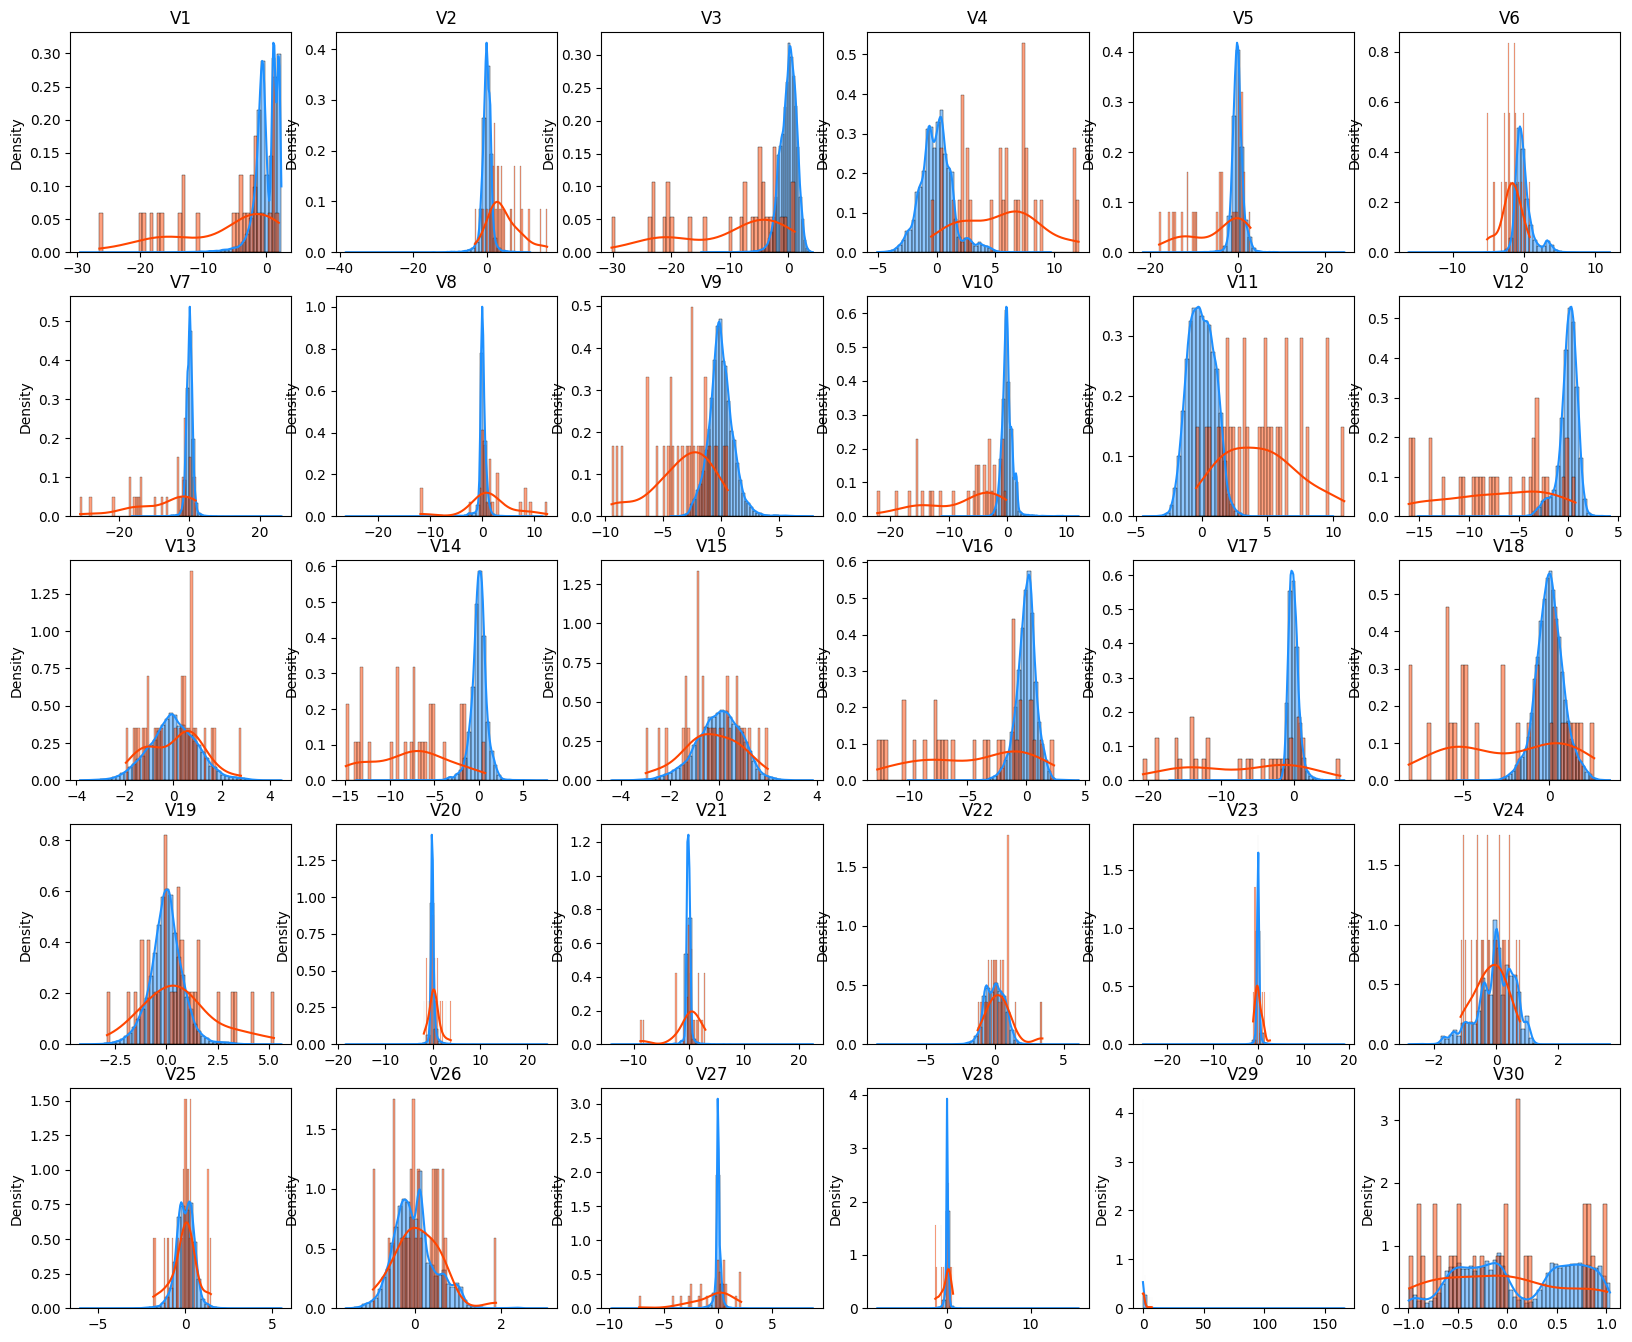

In [178]:
val_class0 = val[val['Class']==0]
val_class1 = val[val['Class']==1]
columns = val.drop('Class', axis=1).columns

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt 
import seaborn as sns 

grid = gridspec.GridSpec(6, 6)
plt.figure(figsize=(20, 20))

for idx, col in enumerate(val_df[columns]):
    ax = plt.subplot(grid[idx])
    sns.histplot(val_class0[col], bins=50, color='dodgerblue', stat='density', kde=True)
    sns.histplot(val_class1[col], bins=50, color='orangered', stat='density', kde=True)
    ax.set_title(col)
    ax.set_xlabel('')
    
plt.show()

In [179]:
train_df = train_df.drop(['V23', 'V29'], axis=1)
test_df = test_df.drop(['V23', 'V29'], axis=1)
val_df = val_df.drop(['V23', 'V29'], axis=1)

In [180]:
len(train_df.columns)

28

In [181]:
val_normal, val_fruad = val_df['Class'].value_counts()
val_contamination = val_fruad / val_normal
print(f'이상 거레 비율: {val_contamination}')

이상 거레 비율: 0.0010551491277433877


In [182]:
# from sklearn.ensemble import RandomForestClassifier
# randomforest = RandomForestClassifier(n_estimators=125,
#                                max_samples=len(train_df),
#                                max_depth=20,
#                                random_state=42,
#                                verbose=0
#                                )

# randomforest.fit(train_df)
# # random forest is supervised learning...

In [183]:
from sklearn.ensemble import IsolationForest
isolationforest = IsolationForest(n_estimators=125,
                               max_samples=len(train_df),
                               contamination=val_contamination,
                               random_state=42,
                               verbose=0
                               )
isolationforest.fit(train_df)

IsolationForest(contamination=0.0010551491277433877, max_samples=113842,
                n_estimators=125, random_state=42)

In [184]:
score = isolationforest.decision_function(train_df.to_numpy())
anomaly = isolationforest.predict(train_df.to_numpy())
train_df['scores'] = score
train_df['anomaly'] = anomaly


/opt/homebrew/anaconda3/envs/mlclass/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/mlclass/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [185]:
anomaly_data = train_df.loc[train_df['anomaly']==-1]
anomaly_data.index
# anomal = pd.DataFrame(anomal)
# anomal

Index([  1188,   2208,   2262,   3494,   3711,   4298,   4324,   4368,   4412,
         4414,
       ...
        92411,  93842,  95358,  98134, 104902, 105084, 105086, 105220, 108226,
       113622],
      dtype='int64', length=121)

In [186]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [187]:
pca = PCA(n_components=3)
scaler = StandardScaler()

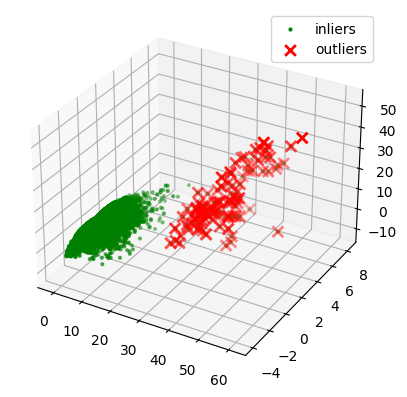

In [188]:
# PCA를 적용하기 전, 데이터 표준화
pca=PCA(n_components=3)
scaler=StandardScaler()

# n_components 매개변수로 축소할 차원의 수 지정
X=scaler.fit_transform(train_df)
X_reduce=pca.fit_transform(X)
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# 시각화를 위해 3D 산점도 사용
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, 
           lw=1, label='inliers', c='green')

# scatter() 함수를 사용하여 축소된 데이터셋을 3D 산점도로 그림
anomaly_index=list(anomaly_data.index)
ax.scatter(X_reduce[anomaly_index,0],X_reduce[anomaly_index,1], X_reduce[anomaly_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [189]:
preds = isolationforest.predict(test_df.to_numpy())
submit = pd.read_csv('./sample_submission.csv')
# submit['Class'] = preds
# submit.to_csv('./submit.csv',index=False)

/opt/homebrew/anaconda3/envs/mlclass/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [190]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [191]:
from sklearn.metrics import accuracy_score
score = accuracy_score(submit['Class'], preds)
score

0.9986456425478761